In [1]:
import itertools, math
import numpy as np
from scipy.stats import distributions
import matplotlib.pyplot as plt
from classes.dpm import BaseMeasure, DPM, NormalBaseMeasure
from classes.likelihood import NormalLikelihood
from classes.variables import Normal, InvGamma

In [2]:
mu1 = -2
mu2 = 2
w1 = .7
xmin = -3
xmax = 3

y = np.concatenate([distributions.norm.rvs(loc=mu1, scale=1, size=int(w1*20)), distributions.norm.rvs(loc=mu2, scale=1, size=int((1-w1)*20))])
y = np.array([-1.00665889, 0.06582354, -0.42930577, -1.79629266, -2.36489645, -0.95595253, -2.9021129, -3.91924953, -1.97221089, -3.35683184, 2.71581309, 1.47543713, 2.96155554, 2.42930198, 2.14831234, 2.29008695, 3.17209821, 2.03396742, 2.26676773, 2.66977811,])
s = [0, 1, 2, 3] * 5
xmin = np.min(y) - 1
xmax = np.max(y) + 1
xrange = np.arange(xmin,xmax,0.01)


mu1_actual = np.mean(y[:13])
mu2_actual = np.mean(y[13:])
std1_actual = np.std(y[:13])
std2_actual = np.std(y[13:])

def f(X, w1=w1) -> np.ndarray:
    return w1*distributions.norm.pdf(X, loc=mu1, scale=1) + (1-w1)*distributions.norm.pdf(X, loc=mu2, scale=1)

def f_data(X, w1=w1) -> np.ndarray:
    return w1*distributions.norm.pdf(X, loc=mu1_actual, scale=std1_actual) + (1-w1)*distributions.norm.pdf(X, loc=mu2_actual, scale=std2_actual)

def f2(X, y=y) -> np.ndarray:
    return distributions.norm.pdf(X, loc=np.mean(y), scale=np.std(y))


In [3]:
mu1_actual

-0.883452473846154

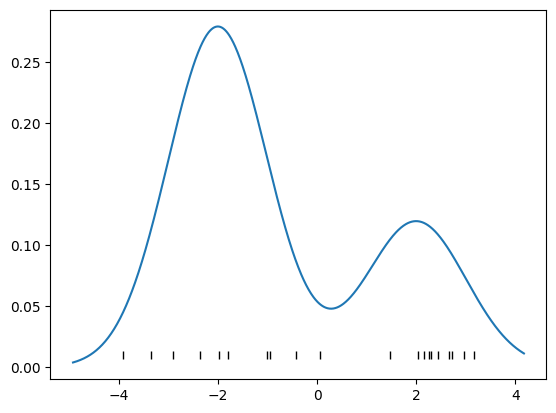

In [4]:
plt.plot(y, [0.01]*len(y), '|', color="k")
plt.plot(xrange, f(xrange))

In [5]:
measures = [
    [-5, 1],
    [-2, 1],
    [2, 1],
    [5, 1]]

base_measure = NormalBaseMeasure([Normal(mu=0,sigma=3), InvGamma()])
dpm = DPM(base_measure, M=0.5)

dpm.set_dataset(y, s)

dpm.set_measures(measures)
dpm.set_weights()

dpm.sample(200)


step:   40/  40 : [0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2]
step:   80/  80 : [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:  120/ 120 : [0, 1, 0, 0, 0, 0, 0, 2, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
step:  160/ 160 : [0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [18]:
def plot_posterior_density(x, results:dict, xmin=xmin, xmax=xmax):
    w = results["w"][:]
    t = results["theta"][:]

    big_X = np.arange(np.min(x)-2, np.max(x)+2, 0.01)

    fig, ax = plt.subplots(1,2, figsize=(12, 6))

    a, b = np.unique(results["n_clusters"], return_counts=True)
    ax[0].bar(x=a, height=b)


    for i in range(len(w)):
        len_w = len(w[i])

        y = []
        mu = np.array(t[i])[:,0]
        sigma = np.array(t[i])[:,1]

        for j in range(len_w):
            y.append(w[i][j] * distributions.norm.pdf(big_X, loc=mu[j], scale=sigma[j]))

            
        y = np.sum(y, axis=0)

        ax[1].plot(big_X, y, color="blue", alpha=0.2)

    ax[1].plot(x, [0.01]*len(x), '|', color="k")
    ax[1].plot(np.arange(xmin, xmax, 0.01), f_data(np.arange(xmin, xmax, 0.01)), color="tab:blue")
    ax[1].plot(np.arange(xmin, xmax, 0.01), f(np.arange(xmin, xmax, 0.01)), linestyle="dashed")
    ax[1].plot(np.arange(xmin, xmax, 0.01), f2(np.arange(xmin, xmax, 0.01)), color="red", linestyle="dashed")


In [19]:
chain = dpm._dpm_chain
results = {"w": chain.w, "theta": chain.phi, "n_clusters": chain.n}

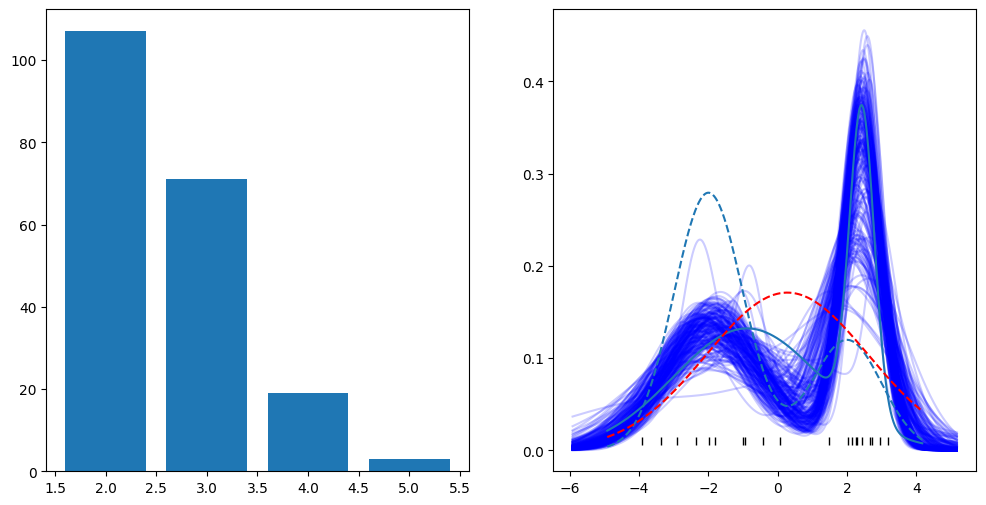

In [20]:
plot_posterior_density(y, results)